# Preamble

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_gph
import json
sns.set()
sns.set_style("ticks")
sns.set_context("talk")
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# Reading In Parameters

In [7]:
import json
with open('../../data/tcm_tacs/serial_2tcm/params_serial_2tcm_set-02.json') as file:
    tmp_params = json.load(file)
tmp_params

{'model': 'Serial 2TCM',
 'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.15}}

In [13]:
MODELS_NUMS = {
    '1tcm': 2, 'serial_2tcm': 3, 'serial_2tcm_k4zero': 2
    }

In [16]:
model_params = {}
for a_model, num in MODELS_NUMS.items():
    model_params[a_model] = {}
    for i in range(num):
        model_params[a_model][f'set-{i:02}'] = {}
        with open(f'../../data/tcm_tacs/{a_model}/params_{a_model}_set-{i:02}.json') as file:
            model_params[a_model][f'set-{i:02}'] = json.load(file)

In [17]:
model_params

{'1tcm': {'set-00': {'model': '1TCM', 'params': {'k1': 1.0, 'k2': 0.25}},
  'set-01': {'model': '1TCM', 'params': {'k1': 0.25, 'k2': 1.0}}},
 'serial_2tcm': {'set-00': {'model': 'Serial 2TCM',
   'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.01, 'k4': 0.01}},
  'set-01': {'model': 'Serial 2TCM',
   'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.01}},
  'set-02': {'model': 'Serial 2TCM',
   'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.15}}},
 'serial_2tcm_k4zero': {'set-00': {'model': 'Serial 2TCM (k4=0)',
   'params': {'k1': 0.5, 'k2': 0.5, 'k3': 0.01}},
  'set-01': {'model': 'Serial 2TCM (k4=0)',
   'params': {'k1': 0.5, 'k2': 0.5, 'k3': 0.25}}}}

In [25]:
def tcm_1tcm_patlak_slope_and_intercept(model_params: dict) -> dict:
    if model_params['k2'] == 0.0:
        slope = model_params['k1']
    else:
        slope=0.0
        
    intercept = None
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept

def tcm_serial_2tcm_k4zero_patlak_slope_and_intercept(model_params: dict) -> dict:
    slope = model_params['k1']*model_params['k3']/(model_params['k2']+model_params['k3'])
    intercept = None
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept

def tcm_serial_2tcm_patlak_slope_and_intercept(model_params: dict) -> dict:
    slope = 0.0
    intercept = None
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_1tcm_logan_slope_and_intercept(model_params: dict) -> dict:
    slope = model_params['k1']/model_params['k2']
    intercept = None
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept

def tcm_serial_2tcm_logan_slope_and_intercept(model_params: dict) -> dict:
    slope = model_params['k1']/model_params['k2']/(1.0+model_params['k3']/model_params['k4'])
    intercept = None
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_calculate_patlak_from_model(model_desc: dict) -> dict:
    model = model_desc['model']
    params= model_desc['params']
    if model == '1TCM':
        return tcm_1tcm_patlak_slope_and_intercept(params)
    elif model == 'Serial 2TCM (k4=0)':
        return tcm_serial_2tcm_k4zero_patlak_slope_and_intercept(params)
    elif model == 'Serial 2TCM':
        return tcm_serial_2tcm_patlak_slope_and_intercept(params)

In [15]:
tcm_calculate_patlak_from_model(model_params['1tcm']['set-00'])

{'slope': 1.0, 'intercept': 0.25}

In [23]:
tcm_calculate_patlak_from_model(model_params['serial_2tcm_k4zero']['set-00'])

{'slope': 0.00980392156862745, 'intercept': None}

# Reading In TACs

In [2]:
pTAC = np.array(np.loadtxt('../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt').T, order='C', dtype=float)

In [8]:
tTAC = np.array(np.loadtxt('../../data/tcm_tacs/serial_2tcm_k4zero/noise_free/tac_2tcm_k4zero_set-00.txt').T, order='C', dtype=float)

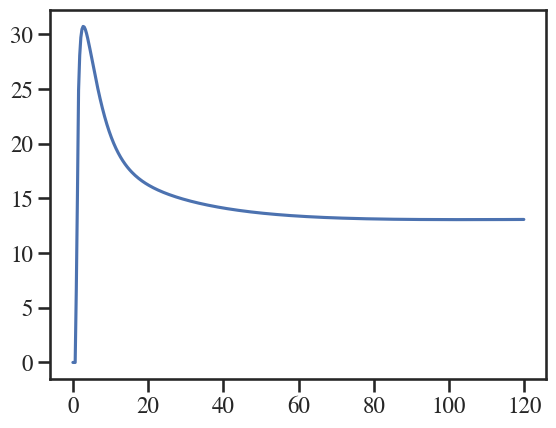

In [9]:
plt.plot(*tTAC)
plt.show()


In [24]:
print(pet_gph.patlak_analysis(input_tac_values=pTAC[1], region_tac_values=tTAC[1], tac_times_in_minutes=pTAC[0], t_thresh_in_minutes=30.0))
print(tcm_calculate_patlak_from_model(model_params['serial_2tcm_k4zero']['set-00']))

[0.00973322 1.07247571]
{'slope': 0.00980392156862745, 'intercept': None}


# Debugging Numba Typing Error

In [8]:
import numba

In [9]:
@numba.njit()
def _line_fitting_make_rhs_matrix_from_xdata(xdata: np.ndarray) -> np.ndarray:
    """Generates the RHS matrix for linear least squares fitting

    Args:
        xdata (np.ndarray): array of independent variable values

    Returns:
        np.ndarray: 2D matrix where first column is `xdata` and the second column is 1s.
        
    """
    out_matrix = np.ones((len(xdata), 2), float)
    out_matrix[:, 0] = xdata
    return out_matrix

# TODO: Check if documentation is good.
@numba.njit()
def fit_line_to_data_using_lls(xdata: np.ndarray, ydata: np.ndarray) -> np.ndarray:
    """Find the linear least squares solution given the x and y variables.
    
    Performs a linear least squares fit to the provided data. Explicitly calls numpy's ``linalg.lstsq`` method by
    constructing the matrix equations. We assume that ``xdata`` and ``ydata`` have the same number of elements.
    
    Args:
        xdata: Array of independent variable values
        ydata: Array of dependent variable values

    Returns:
       Linear least squares solution. (m, b) values
       
    """
    make_2d_matrix = _line_fitting_make_rhs_matrix_from_xdata
    matrix = make_2d_matrix(xdata)
    fit_ans = np.linalg.lstsq(matrix, ydata)[0]
    return fit_ans


@numba.njit()
def cumulative_trapezoidal_integral(xdata: np.ndarray, ydata: np.ndarray, initial: float = 0.0) -> np.ndarray:
    """Calculates the cumulative integral of `ydata` over `xdata` using the trapezoidal rule.
    
    This function is based `heavily` on the ``scipy.integrate.cumtrapz`` implementation.
    `source <https://github.com/scipy/scipy/blob/v0.18.1/scipy/integrate/quadrature.py#L206>`_.
    This implementation only works for 1D arrays and was implemented to work with ``numba``.
    
    Args:
        xdata (np.ndarray): Array for the integration coordinate.
        ydata (np.ndarray): Array for the values to integrate

    Returns:
        np.ndarray: Cumulative integral of ``ydata`` over ``xdata``
    """
    dx = np.diff(xdata)
    cum_int = np.zeros(len(xdata))
    cum_int[0] = initial
    cum_int[1:] = np.cumsum(dx * (ydata[1:] + ydata[:-1]) / 2.0)
    
    return cum_int

# TODO: Add references for the TCMs and Patlak. Could maybe rely on Turku PET Center.
# TODO: Handle cases when tac_vals = 0.0. Might be able to use t_thresh so that we are past the 0-values.
@numba.njit()
def calculate_patlak_x(tac_times: np.ndarray, tac_vals: np.ndarray) -> np.ndarray:
    r"""Calculates the x-variable in Patlak analysis (:math:`\frac{\int_{0}^{T}f(t)\mathrm{d}t}{f(T)}`).
    
    Patlak-Gjedde analysis is a linearization of the 2-TCM with irreversible uptake in the second compartment.
    Therefore, we essentially have to fit a line to some data :math:`y = mx+b`. This function calculates the :math:`x`
    variable for Patlak analysis where,
    .. math::
        x = \frac{\int_{0}_{T} C_\mathrm{P}(t) \mathrm{d}t}{C_\mathrm{P}(t)},
    
    where further :math:`C_\mathrm{P}` is usually the plasma TAC.
    
    Args:
        tac_times (np.ndarray): Array containing the sampled times.
        tac_vals (np.ndarray): Array for activity values at the sampled times.

    Returns:
        np.ndarray: Patlak x-variable. Cumulative integral of activity divided by activity.
    """
    cumulative_integral = cumulative_trapezoidal_integral(xdata=tac_times, ydata=tac_vals, initial=0.0)
    
    return cumulative_integral / tac_vals


@numba.njit()
def get_index_from_threshold(times_in_minutes: np.ndarray, t_thresh_in_minutes: float) -> int:
    """Get the index after which all times are greater than the threshold.

    Args:
        times_in_minutes (np.ndarray): Array containing times in minutes.
        t_thresh_in_minutes (float): Threshold time in minutes.

    Returns:
        int: Index for first time greater than or equal to the threshold time.
        
    Notes:
        If the threshold value is larger than the array, we return -1.
    """
    if t_thresh_in_minutes > np.max(times_in_minutes):
        return -1
    else:
        return np.argwhere(times_in_minutes >= t_thresh_in_minutes)[0, 0]


# TODO: Add more detailed documentation.
@numba.njit()
def patlak_analysis(input_tac_values: np.ndarray,
                    region_tac_values: np.ndarray,
                    tac_times_in_minutes: np.ndarray,
                    t_thresh_in_minutes: float) -> np.ndarray:
    """Performs Patlak-Gjedde analysis given the input TAC, region TAC, times and threshold.
    
    Args:
        input_tac_values (np.ndarray):
        region_tac_values (np.ndarray):
        tac_times_in_minutes (np.ndarray):
        t_thresh_in_minutes (np.ndarray):

    Returns:
        np.ndarray: Array containing :math:`(K_{1}, V_{0})` values.
    """
    t_thresh = get_index_from_threshold(times_in_minutes=tac_times_in_minutes, t_thresh_in_minutes=t_thresh_in_minutes)
    
    patlak_x = calculate_patlak_x(tac_times=tac_times_in_minutes, tac_vals=input_tac_values)
    patlak_y = region_tac_values / input_tac_values
    
    patlak_values = fit_line_to_data_using_lls(xdata=patlak_x[t_thresh:], ydata=patlak_y[t_thresh:])
    
    return patlak_values

In [15]:
patlak_analysis(input_tac_values=pTAC[1], region_tac_values=tTAC[1], tac_times_in_minutes=pTAC[0], t_thresh_in_minutes=30.0)

array([0.00232219, 0.83178168])

array([[  0.      ,   0.      ],
       [  0.301196,   0.      ],
       [  0.602392,   0.      ],
       [  0.903588,  44.3419  ],
       [  1.204784,  63.25601 ],
       [  1.50598 ,  78.05534 ],
       [  1.807176,  44.15823 ],
       [  2.108372,  36.8047  ],
       [  2.409568,  32.40197 ],
       [  2.710764,  29.6718  ],
       [  3.01196 ,  27.8252  ],
       [  3.313156,  26.47125 ],
       [  3.614352,  25.38668 ],
       [  3.915548,  24.47599 ],
       [  4.216744,  23.67583 ],
       [  4.51794 ,  22.96001 ],
       [  4.819136,  22.30221 ],
       [  5.120332,  21.69347 ],
       [  5.421528,  21.12756 ],
       [  5.722724,  20.59989 ],
       [  6.02392 ,  20.10685 ],
       [  6.325116,  19.64527 ],
       [  6.626312,  19.21229 ],
       [  6.927508,  18.80526 ],
       [  7.228704,  18.42163 ],
       [  7.5299  ,  18.05899 ],
       [  7.831096,  17.71562 ],
       [  8.132292,  17.3972  ],
       [  8.433488,  17.09405 ],
       [  8.734684,  16.80427 ],
       [  